In [ ]:
from scipy.io import loadmat
import numpy as np
from PIL import Image
from matplotlib.pyplot import imshow
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
%matplotlib inline
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, datasets, models
import os
import torch
import torch.nn as nn
import torch.nn.functional as F

import torch.optim as optim
from torch.optim import lr_scheduler
import time
import copy

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
%cd drive/MyDrive/MagistracyScience/NucleiSegmentationAI

/content/drive/MyDrive/MagistracyScience/NucleiSegmentationAI


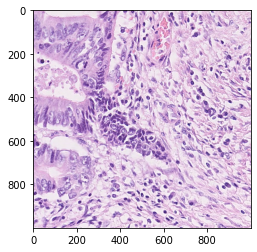

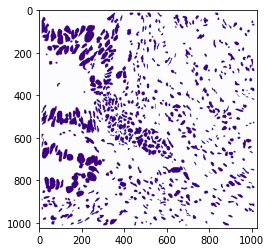

In [ ]:
############################################
# Display Image and its corresponding Mask #
############################################
x = loadmat('./Train/Labels/train_1.mat')
img=mpimg.imread('./Train/Images/train_1.png')
imgplot = plt.imshow(img)
plt.show()
imshow(np.pad((x['inst_map']>=1).astype(int),12), cmap='Purples')

In [ ]:
class NucleiDataset(Dataset):
    def __init__(self, image_path, mask_path, transform=None):
        self.img_ls = [image_path+i for i in sorted(os.listdir(image_path))]
        self.mask_ls = [ mask_path+i for i in sorted(os.listdir(mask_path))]
        self.transform = transform

    def __len__(self):
        return len(self.img_ls)

    def __getitem__(self, idx):
        img_name = self.img_ls[idx]
        img = Image.open(img_name).convert('RGB')
        img.load()
        mask_name = self.mask_ls[idx]
        mask = np.pad((loadmat(mask_name)['inst_map']>=1).astype(int),12)  
        if self.transform:
            img = self.transform(img)

        return img, mask


trans = transforms.Compose([
    transforms.Pad(12),    # given image is 1000x1000, pad it to make it 1024x1024
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]) # imagenet normalization
])

label_path = "./Train/Labels/"
img_path = "./Train/Images/"

train_set = NucleiDataset(img_path, label_path, transform = trans)

batch_size = 4  #my gpu is 8gb, using batchsize of 2 already insufficient memory, so i use batch size 1

train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True, num_workers=1)

torch.Size([4, 3, 1024, 1024]) torch.Size([4, 1024, 1024])


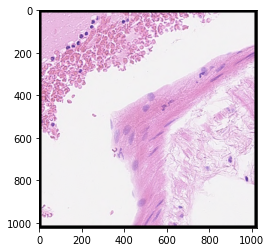

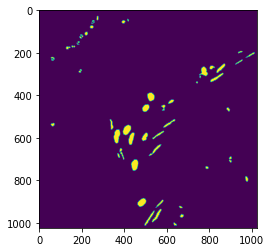

In [ ]:
def reverse_transform(inp):
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    inp = (inp * 255).astype(np.uint8)

    return inp


inputs, masks = next(iter(train_loader))

print(inputs.shape, masks.shape)  #shapes of our inputs to the model and loss function

plt.imshow(reverse_transform(inputs[0]))
plt.show()
imshow(masks[0])

In [ ]:
######################
# Model Architecture #
######################

def convrelu(in_channels, out_channels, kernel, padding):
    return nn.Sequential(
        nn.Conv2d(in_channels, out_channels, kernel, padding=padding),
        nn.ReLU(inplace=True),
    )


class ResNetUNet(nn.Module):
    def __init__(self, n_class):
        super().__init__()

        self.base_model = models.resnet18(pretrained=True)
        self.base_layers = list(self.base_model.children())

        self.layer0 = nn.Sequential(*self.base_layers[:3]) # size=(N, 64, x.H/2, x.W/2)
        self.layer0_1x1 = convrelu(64, 64, 1, 0)
        self.layer1 = nn.Sequential(*self.base_layers[3:5]) # size=(N, 64, x.H/4, x.W/4)
        self.layer1_1x1 = convrelu(64, 64, 1, 0)
        self.layer2 = self.base_layers[5]  # size=(N, 128, x.H/8, x.W/8)
        self.layer2_1x1 = convrelu(128, 128, 1, 0)
        self.layer3 = self.base_layers[6]  # size=(N, 256, x.H/16, x.W/16)
        self.layer3_1x1 = convrelu(256, 256, 1, 0)
        self.layer4 = self.base_layers[7]  # size=(N, 512, x.H/32, x.W/32)
        self.layer4_1x1 = convrelu(512, 512, 1, 0)

        self.upsample = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)

        self.conv_up3 = convrelu(256 + 512, 512, 3, 1)
        self.conv_up2 = convrelu(128 + 512, 256, 3, 1)
        self.conv_up1 = convrelu(64 + 256, 256, 3, 1)
        self.conv_up0 = convrelu(64 + 256, 128, 3, 1)

        self.conv_original_size0 = convrelu(3, 64, 3, 1)
        self.conv_original_size1 = convrelu(64, 64, 3, 1)
        self.conv_original_size2 = convrelu(64 + 128, 64, 3, 1)

        self.conv_last = nn.Conv2d(64, n_class, 1)

    def forward(self, input):
        x_original = self.conv_original_size0(input)
        x_original = self.conv_original_size1(x_original)

        layer0 = self.layer0(input)
        layer1 = self.layer1(layer0)
        layer2 = self.layer2(layer1)
        layer3 = self.layer3(layer2)
        layer4 = self.layer4(layer3)
        
        layer4 = self.layer4_1x1(layer4)
        x = self.upsample(layer4)
        layer3 = self.layer3_1x1(layer3)
        x = torch.cat([x, layer3], dim=1)
        x = self.conv_up3(x)

        x = self.upsample(x)
        layer2 = self.layer2_1x1(layer2)
        x = torch.cat([x, layer2], dim=1)
        x = self.conv_up2(x)

        x = self.upsample(x)
        layer1 = self.layer1_1x1(layer1)
        x = torch.cat([x, layer1], dim=1)
        x = self.conv_up1(x)

        x = self.upsample(x)
        layer0 = self.layer0_1x1(layer0)
        x = torch.cat([x, layer0], dim=1)
        x = self.conv_up0(x)

        x = self.upsample(x)
        x = torch.cat([x, x_original], dim=1)
        x = self.conv_original_size2(x)

        out = self.conv_last(x)

        return out

In [ ]:
###################################################################
# Loss function that combines Binary Cross Entropy with Dice loss #
###################################################################

# Model output is (N, 1, 1024,1024), where N = batch size, Thus you will see that i squeeze the 2nd dimension

def weighted_loss(pred, targ, bce_weight=0.5, smooth=1.):
    
    bce = F.binary_cross_entropy_with_logits(pred.squeeze(dim=1), targ)
    
    pred = torch.sigmoid(pred)
    
    pred = pred.contiguous().squeeze(dim=1)  
    targ = targ.contiguous()  

    intersection = (pred * targ).sum(dim=1).sum(dim=1)
    dice = (1 - ((2. * intersection + smooth) / (pred.sum(dim=1).sum(dim=1) + targ.sum(dim=1).sum(dim=1) + smooth)))
    
    loss = bce * bce_weight + dice.mean() * (1 - bce_weight)
    
    return loss, dice, bce

In [ ]:
def update_ema_variables(alpha, global_step):
    # Use the true average until the exponential average is more correct
    alpha = min(1 - 1 / (global_step + 1), alpha)
    #print("ema_aprams here")
    for ema_param, param in zip(ema_model.parameters(), model.parameters()):
        ema_param.data.mul_(alpha).add_(1 - alpha, param.data)
    #print(ema_param)
  



In [ ]:
def sigmoid_rampup(current, rampup_length):
  if rampup_length == 0:
      return 1.0
  else:
      current = np.clip(current, 0.0, rampup_length)
      phase = 1.0 - current / rampup_length
      return float(np.exp(-5.0 * phase * phase))

def get_current_consistency_weight(epoch):
    # Consistency ramp-up from https://arxiv.org/abs/1610.02242
    consistency = 0.1
    consistency_rampup = 200.0
    return consistency * sigmoid_rampup(epoch, consistency_rampup)


In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [ ]:
def train_model(optimizer, scheduler, num_epochs=25):
    best_model_wts = copy.deepcopy(model.state_dict())
    best_loss = 1e10
    ict_alpha = 0.21
    ema_decay = 0.99
    labeled_bs = 2
    loss_ls = []
    iter_num = 0
    
    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        since = time.time()
        
        


        supervised_loss = 0

        
        for inputs, masks in train_loader:
            if len(inputs) != 4:
              break

            model.train()
            inputs = inputs.to(device)
            masks = masks.to(device).float()
            #print(len(inputs), len(unlabeled_volume_batch))
            unlabeled_volume_batch = inputs[labeled_bs:]
            labeled_volume_batch = inputs[:labeled_bs]

            #print(len(inputs), len(unlabeled_volume_batch), len(labeled_volume_batch))

            #print(unlabeled_volume_batch)

            #print(inputs)

            #print(unlabeled_volume_batch)

            #ICT mix factors
            ict_mix_factors = np.random.beta(
                ict_alpha, ict_alpha, size=((labeled_bs // 2, 1, 1, 1)))
            ict_mix_factors = torch.tensor(
                ict_mix_factors, dtype=torch.float).cuda()
            unlabeled_volume_batch_0 = unlabeled_volume_batch[0: labeled_bs // 2, ...]
            unlabeled_volume_batch_1 = unlabeled_volume_batch[labeled_bs // 2:, ...]


            #print(unlabeled_volume_batch_1)
            
            
            #optimizer.zero_grad()
            #outputs = model(inputs)
            

            #print(unlabeled_volume_batch_0, unlabeled_volume_batch_1)
            
          

            #Mix images
            batch_ux_mixed = unlabeled_volume_batch_0 * \
                (1.0 - ict_mix_factors) + \
                unlabeled_volume_batch_1 * ict_mix_factors
            
            #print(batch_ux_mixed)
            input_volume_batch = torch.cat(
                [labeled_volume_batch, batch_ux_mixed], dim=0)
            #print(batch_ux_mixed, len(batch_ux_mixed))
            

            outputs = model(input_volume_batch)
            #outputs_soft = torch.softmax(outputs, dim=1)
            #print(outputs, "outputs")
            #print(torch.softmax(unlabeled_volume_batch_0, dim=1))
            with torch.no_grad():
              #unlabeled_output = torch.softmax(ema_model(unlabeled_volume_batch), dim=1)
              ema_output_ux0 = ema_model(unlabeled_volume_batch_0)
              ema_output_ux1 = ema_model(unlabeled_volume_batch_1)
              batch_pred_mixed = ema_output_ux0 * \
                  (1.0 - ict_mix_factors) + ema_output_ux1 * ict_mix_factors
            #print(len(batch_pred_mixed), len(outputs_soft[labeled_bs:]))

            supervised_loss, dice, bce = weighted_loss(outputs[:labeled_bs], masks[:labeled_bs], bce_weight=0.5)
            #supervised_loss.backward()
            #optimizer.step()
            iter_num += 1
            #n_samples = len(inputs)
            #supervised_loss = (supervised_loss / n_samples).item()

            #dice = (epoch_dice.mean()).item()
            #bce = (epoch_bce / n_samples).item()
            #print(unlabeled_output, "and", outputs_soft[labeled_bs:])
            
            consistency_weight = get_current_consistency_weight(iter_num // 150)
            #print(consistency_weight)
            #print(batch_pred_mixed, "hey")
            #consistency_loss = torch.mean(
            #    (outputs_soft[15:] - batch_pred_mixed) ** 2)
            #print(torch.mean((outputs_soft[labeled_bs:] - batch_pred_mixed) ** 2), 'fff')
            #print(batch_pred_mixed)
            consistency_loss = torch.mean(
                (outputs[labeled_bs:] - batch_pred_mixed) ** 2)
            #print(batch_pred_mixed, "batch_pred_mixed", consistency_loss, "loss")
            #if consistency_loss == "nan" or consistency_loss == "NaN":
            #    consistency_loss = 0
            #print("lol", consistency_loss)
            loss = supervised_loss + consistency_weight * consistency_loss

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            update_ema_variables(ema_decay, iter_num)


            #lr_ = base_lr * (1.0 - iter_num / max_iterations) ** 0.9
            #for param_group in optimizer.param_groups:
            #    param_group['lr'] = lr_

          # вейт-декей???
        
        #supervised_loss /= len(train_loader)
        #dice /= len(train_loader)
        #bce /= len(train_loader)

        #consistency_loss /= len(train_loader)
        #loss /= len(train_loader)


        print("epoch loss:", supervised_loss)
        print("epoch dice:", dice)
        print("epoch bce:", bce)

        print("unsupervised loss", consistency_loss)
        print("loss", loss)


        loss_ls.append(loss)
        
        if (epoch+1)%5==0:
            print("\n","Input Image")
            plt.imshow(reverse_transform(inputs.to('cpu').detach()[0]))
            plt.show()
            print("Predicted Mask Sigmoid")
            plt.imshow(outputs.to('cpu').detach().numpy()[0][0],cmap='gray')
            plt.show()
            print("Actual Mask")
            plt.imshow(masks.to('cpu').detach()[0],cmap='gray')
            plt.show()
        
        time_elapsed = time.time() - since
        print('{:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60),"\n")
    
    return loss_ls

Epoch 0/59
----------
epoch loss: tensor(0.6684, device='cuda:0', grad_fn=<AddBackward0>)
epoch dice: tensor([0.7158, 0.9423], device='cuda:0', grad_fn=<RsubBackward1>)
epoch bce: tensor(0.5078, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
unsupervised loss tensor(0.7081, device='cuda:0', grad_fn=<MeanBackward0>)
loss tensor(0.6689, device='cuda:0', grad_fn=<AddBackward0>)
0m 3s 

Epoch 1/59
----------
epoch loss: tensor(0.6029, device='cuda:0', grad_fn=<AddBackward0>)
epoch dice: tensor([0.9668, 0.9093], device='cuda:0', grad_fn=<RsubBackward1>)
epoch bce: tensor(0.2677, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
unsupervised loss tensor(0.2949, device='cuda:0', grad_fn=<MeanBackward0>)
loss tensor(0.6031, device='cuda:0', grad_fn=<AddBackward0>)
0m 3s 

Epoch 2/59
----------
epoch loss: tensor(0.6127, device='cuda:0', grad_fn=<AddBackward0>)
epoch dice: tensor([0.7448, 0.7007], device='cuda:0', grad_fn=<RsubBackward1>)
epoch b

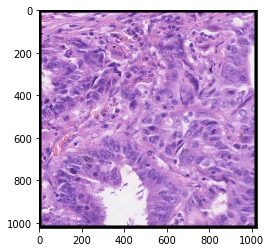

Predicted Mask Sigmoid


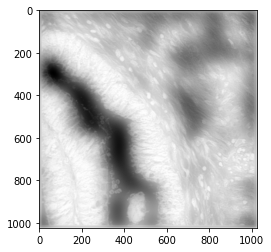

Actual Mask


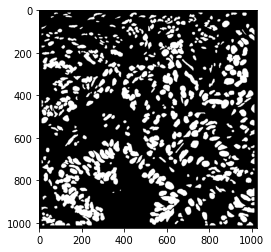

0m 3s 

Epoch 5/59
----------
epoch loss: tensor(0.5156, device='cuda:0', grad_fn=<AddBackward0>)
epoch dice: tensor([0.5845, 0.7857], device='cuda:0', grad_fn=<RsubBackward1>)
epoch bce: tensor(0.3461, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
unsupervised loss tensor(3.4987, device='cuda:0', grad_fn=<MeanBackward0>)
loss tensor(0.5179, device='cuda:0', grad_fn=<AddBackward0>)
0m 3s 

Epoch 6/59
----------
epoch loss: tensor(0.4958, device='cuda:0', grad_fn=<AddBackward0>)
epoch dice: tensor([0.6169, 0.9172], device='cuda:0', grad_fn=<RsubBackward1>)
epoch bce: tensor(0.2246, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
unsupervised loss tensor(0.1553, device='cuda:0', grad_fn=<MeanBackward0>)
loss tensor(0.4959, device='cuda:0', grad_fn=<AddBackward0>)
0m 3s 

Epoch 7/59
----------
epoch loss: tensor(0.4627, device='cuda:0', grad_fn=<AddBackward0>)
epoch dice: tensor([0.5676, 0.5837], device='cuda:0', grad_fn=<RsubBackward1>)

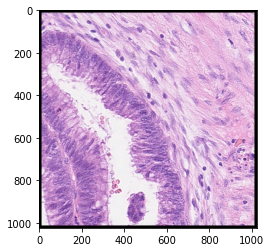

Predicted Mask Sigmoid


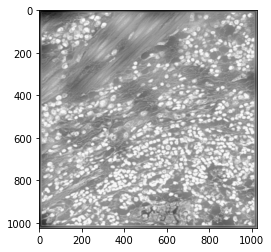

Actual Mask


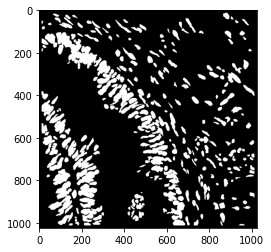

0m 3s 

Epoch 10/59
----------
epoch loss: tensor(0.4000, device='cuda:0', grad_fn=<AddBackward0>)
epoch dice: tensor([0.4599, 0.6800], device='cuda:0', grad_fn=<RsubBackward1>)
epoch bce: tensor(0.2300, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
unsupervised loss tensor(7.0816, device='cuda:0', grad_fn=<MeanBackward0>)
loss tensor(0.4048, device='cuda:0', grad_fn=<AddBackward0>)
0m 3s 

Epoch 11/59
----------
epoch loss: tensor(0.3761, device='cuda:0', grad_fn=<AddBackward0>)
epoch dice: tensor([0.5851, 0.6911], device='cuda:0', grad_fn=<RsubBackward1>)
epoch bce: tensor(0.1140, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
unsupervised loss tensor(1.4367, device='cuda:0', grad_fn=<MeanBackward0>)
loss tensor(0.3770, device='cuda:0', grad_fn=<AddBackward0>)
0m 3s 

Epoch 12/59
----------
epoch loss: tensor(0.3764, device='cuda:0', grad_fn=<AddBackward0>)
epoch dice: tensor([0.4855, 0.6059], device='cuda:0', grad_fn=<RsubBackward

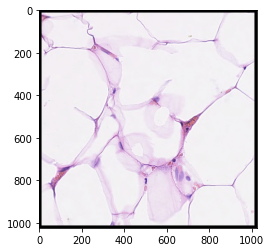

Predicted Mask Sigmoid


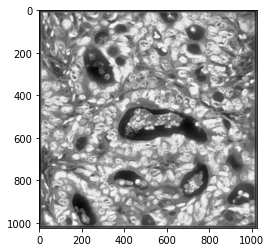

Actual Mask


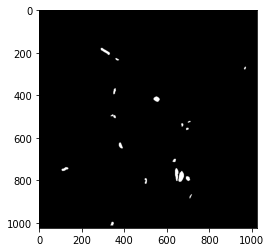

0m 3s 

Epoch 15/59
----------
epoch loss: tensor(0.3141, device='cuda:0', grad_fn=<AddBackward0>)
epoch dice: tensor([0.4264, 0.4570], device='cuda:0', grad_fn=<RsubBackward1>)
epoch bce: tensor(0.1865, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
unsupervised loss tensor(9.3396, device='cuda:0', grad_fn=<MeanBackward0>)
loss tensor(0.3204, device='cuda:0', grad_fn=<AddBackward0>)
0m 3s 

Epoch 16/59
----------
epoch loss: tensor(0.2609, device='cuda:0', grad_fn=<AddBackward0>)
epoch dice: tensor([0.3283, 0.4162], device='cuda:0', grad_fn=<RsubBackward1>)
epoch bce: tensor(0.1496, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
unsupervised loss tensor(16.1087, device='cuda:0', grad_fn=<MeanBackward0>)
loss tensor(0.2718, device='cuda:0', grad_fn=<AddBackward0>)
0m 3s 

Epoch 17/59
----------
epoch loss: tensor(0.3533, device='cuda:0', grad_fn=<AddBackward0>)
epoch dice: tensor([0.7078, 0.4686], device='cuda:0', grad_fn=<RsubBackwar

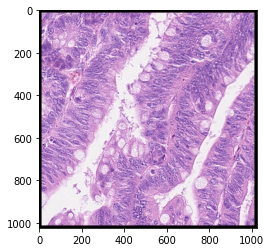

Predicted Mask Sigmoid


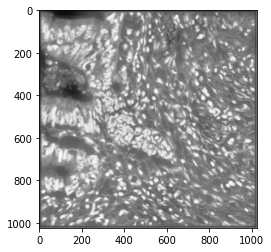

Actual Mask


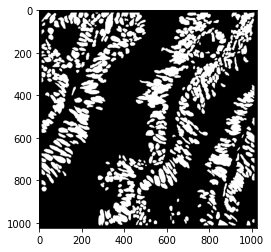

0m 3s 

Epoch 20/59
----------
epoch loss: tensor(0.2645, device='cuda:0', grad_fn=<AddBackward0>)
epoch dice: tensor([0.3216, 0.3352], device='cuda:0', grad_fn=<RsubBackward1>)
epoch bce: tensor(0.2007, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
unsupervised loss tensor(5.1804, device='cuda:0', grad_fn=<MeanBackward0>)
loss tensor(0.2680, device='cuda:0', grad_fn=<AddBackward0>)
0m 3s 

Epoch 21/59
----------
epoch loss: tensor(0.2584, device='cuda:0', grad_fn=<AddBackward0>)
epoch dice: tensor([0.3356, 0.3004], device='cuda:0', grad_fn=<RsubBackward1>)
epoch bce: tensor(0.1987, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
unsupervised loss tensor(8.5499, device='cuda:0', grad_fn=<MeanBackward0>)
loss tensor(0.2641, device='cuda:0', grad_fn=<AddBackward0>)
0m 3s 

Epoch 22/59
----------
epoch loss: tensor(0.2996, device='cuda:0', grad_fn=<AddBackward0>)
epoch dice: tensor([0.2801, 0.5115], device='cuda:0', grad_fn=<RsubBackward

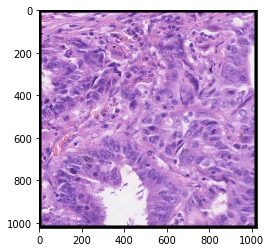

Predicted Mask Sigmoid


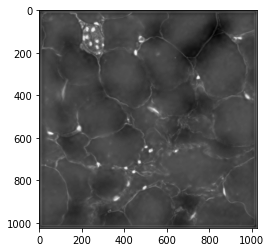

Actual Mask


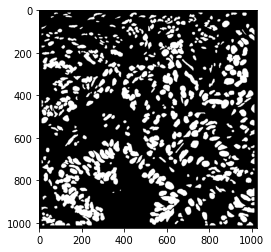

0m 4s 

Epoch 25/59
----------
epoch loss: tensor(0.2254, device='cuda:0', grad_fn=<AddBackward0>)
epoch dice: tensor([0.2357, 0.1760], device='cuda:0', grad_fn=<RsubBackward1>)
epoch bce: tensor(0.2450, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
unsupervised loss tensor(12.6789, device='cuda:0', grad_fn=<MeanBackward0>)
loss tensor(0.2344, device='cuda:0', grad_fn=<AddBackward0>)
0m 3s 

Epoch 26/59
----------
epoch loss: tensor(0.2238, device='cuda:0', grad_fn=<AddBackward0>)
epoch dice: tensor([0.1837, 0.3866], device='cuda:0', grad_fn=<RsubBackward1>)
epoch bce: tensor(0.1625, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
unsupervised loss tensor(5.4952, device='cuda:0', grad_fn=<MeanBackward0>)
loss tensor(0.2277, device='cuda:0', grad_fn=<AddBackward0>)
0m 3s 

Epoch 27/59
----------
epoch loss: tensor(0.2208, device='cuda:0', grad_fn=<AddBackward0>)
epoch dice: tensor([0.3213, 0.2632], device='cuda:0', grad_fn=<RsubBackwar

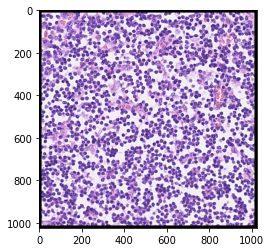

Predicted Mask Sigmoid


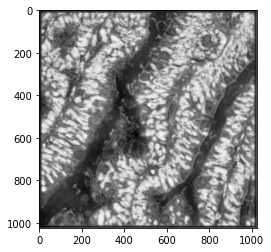

Actual Mask


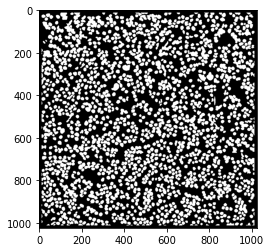

0m 3s 

Epoch 30/59
----------
epoch loss: tensor(0.2096, device='cuda:0', grad_fn=<AddBackward0>)
epoch dice: tensor([0.2629, 0.2203], device='cuda:0', grad_fn=<RsubBackward1>)
epoch bce: tensor(0.1776, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
unsupervised loss tensor(5.3336, device='cuda:0', grad_fn=<MeanBackward0>)
loss tensor(0.2134, device='cuda:0', grad_fn=<AddBackward0>)
0m 3s 

Epoch 31/59
----------
epoch loss: tensor(0.3164, device='cuda:0', grad_fn=<AddBackward0>)
epoch dice: tensor([0.3288, 0.2648], device='cuda:0', grad_fn=<RsubBackward1>)
epoch bce: tensor(0.3361, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
unsupervised loss tensor(12.1777, device='cuda:0', grad_fn=<MeanBackward0>)
loss tensor(0.3251, device='cuda:0', grad_fn=<AddBackward0>)
0m 3s 

Epoch 32/59
----------
epoch loss: tensor(0.1580, device='cuda:0', grad_fn=<AddBackward0>)
epoch dice: tensor([0.2963, 0.2254], device='cuda:0', grad_fn=<RsubBackwar

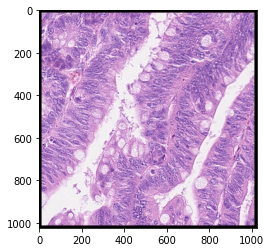

Predicted Mask Sigmoid


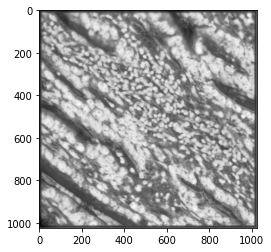

Actual Mask


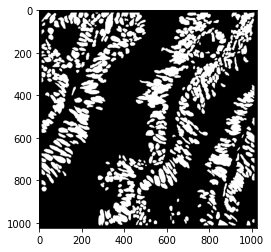

0m 4s 

Epoch 35/59
----------
epoch loss: tensor(0.1501, device='cuda:0', grad_fn=<AddBackward0>)
epoch dice: tensor([0.2511, 0.2673], device='cuda:0', grad_fn=<RsubBackward1>)
epoch bce: tensor(0.0409, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
unsupervised loss tensor(4.6191, device='cuda:0', grad_fn=<MeanBackward0>)
loss tensor(0.1533, device='cuda:0', grad_fn=<AddBackward0>)
0m 3s 

Epoch 36/59
----------
epoch loss: tensor(0.2163, device='cuda:0', grad_fn=<AddBackward0>)
epoch dice: tensor([0.2675, 0.2333], device='cuda:0', grad_fn=<RsubBackward1>)
epoch bce: tensor(0.1822, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
unsupervised loss tensor(6.3367, device='cuda:0', grad_fn=<MeanBackward0>)
loss tensor(0.2208, device='cuda:0', grad_fn=<AddBackward0>)
0m 3s 

Epoch 37/59
----------
epoch loss: tensor(0.2704, device='cuda:0', grad_fn=<AddBackward0>)
epoch dice: tensor([0.2768, 0.4863], device='cuda:0', grad_fn=<RsubBackward

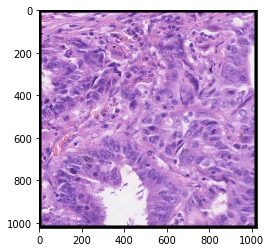

Predicted Mask Sigmoid


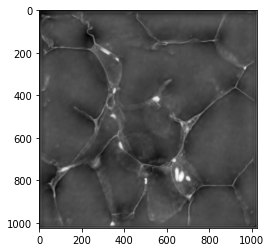

Actual Mask


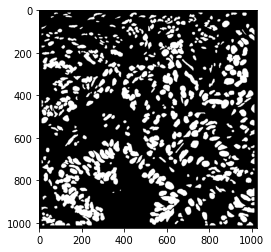

0m 4s 

Epoch 40/59
----------
epoch loss: tensor(0.2104, device='cuda:0', grad_fn=<AddBackward0>)
epoch dice: tensor([0.2282, 0.2304], device='cuda:0', grad_fn=<RsubBackward1>)
epoch bce: tensor(0.1915, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
unsupervised loss tensor(12.9425, device='cuda:0', grad_fn=<MeanBackward0>)
loss tensor(0.2196, device='cuda:0', grad_fn=<AddBackward0>)
0m 3s 

Epoch 41/59
----------
epoch loss: tensor(0.1732, device='cuda:0', grad_fn=<AddBackward0>)
epoch dice: tensor([0.2503, 0.2330], device='cuda:0', grad_fn=<RsubBackward1>)
epoch bce: tensor(0.1048, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
unsupervised loss tensor(2.7007, device='cuda:0', grad_fn=<MeanBackward0>)
loss tensor(0.1751, device='cuda:0', grad_fn=<AddBackward0>)
0m 3s 

Epoch 42/59
----------
epoch loss: tensor(0.1890, device='cuda:0', grad_fn=<AddBackward0>)
epoch dice: tensor([0.2228, 0.2557], device='cuda:0', grad_fn=<RsubBackwar

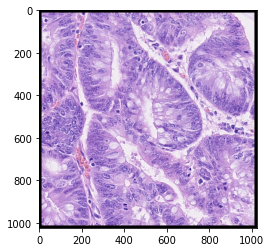

Predicted Mask Sigmoid


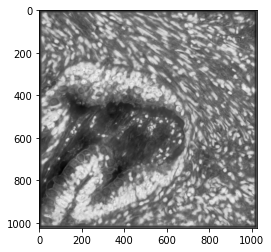

Actual Mask


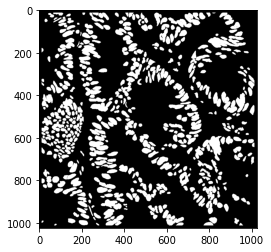

0m 3s 

Epoch 45/59
----------
epoch loss: tensor(0.2101, device='cuda:0', grad_fn=<AddBackward0>)
epoch dice: tensor([0.2838, 0.2673], device='cuda:0', grad_fn=<RsubBackward1>)
epoch bce: tensor(0.1446, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
unsupervised loss tensor(8.1049, device='cuda:0', grad_fn=<MeanBackward0>)
loss tensor(0.2158, device='cuda:0', grad_fn=<AddBackward0>)
0m 3s 

Epoch 46/59
----------
epoch loss: tensor(0.2611, device='cuda:0', grad_fn=<AddBackward0>)
epoch dice: tensor([0.2633, 0.2212], device='cuda:0', grad_fn=<RsubBackward1>)
epoch bce: tensor(0.2799, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
unsupervised loss tensor(7.0487, device='cuda:0', grad_fn=<MeanBackward0>)
loss tensor(0.2661, device='cuda:0', grad_fn=<AddBackward0>)
0m 3s 

Epoch 47/59
----------
epoch loss: tensor(0.1470, device='cuda:0', grad_fn=<AddBackward0>)
epoch dice: tensor([0.3805, 0.1768], device='cuda:0', grad_fn=<RsubBackward

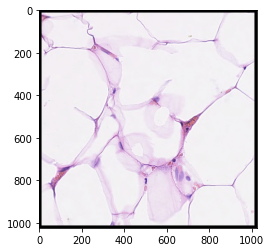

Predicted Mask Sigmoid


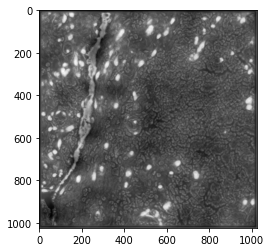

Actual Mask


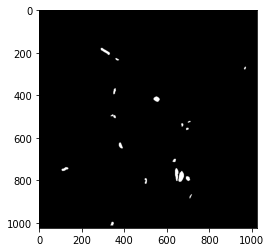

0m 3s 

Epoch 50/59
----------
epoch loss: tensor(0.2037, device='cuda:0', grad_fn=<AddBackward0>)
epoch dice: tensor([0.2203, 0.2498], device='cuda:0', grad_fn=<RsubBackward1>)
epoch bce: tensor(0.1723, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
unsupervised loss tensor(5.0299, device='cuda:0', grad_fn=<MeanBackward0>)
loss tensor(0.2074, device='cuda:0', grad_fn=<AddBackward0>)
0m 3s 

Epoch 51/59
----------
epoch loss: tensor(0.2126, device='cuda:0', grad_fn=<AddBackward0>)
epoch dice: tensor([0.2168, 0.2001], device='cuda:0', grad_fn=<RsubBackward1>)
epoch bce: tensor(0.2167, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
unsupervised loss tensor(2.1786, device='cuda:0', grad_fn=<MeanBackward0>)
loss tensor(0.2142, device='cuda:0', grad_fn=<AddBackward0>)
0m 3s 

Epoch 52/59
----------
epoch loss: tensor(0.1762, device='cuda:0', grad_fn=<AddBackward0>)
epoch dice: tensor([0.2108, 0.2258], device='cuda:0', grad_fn=<RsubBackward

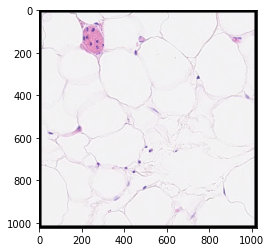

Predicted Mask Sigmoid


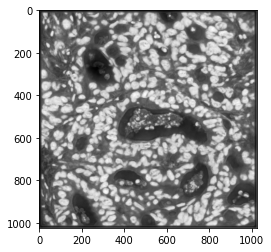

Actual Mask


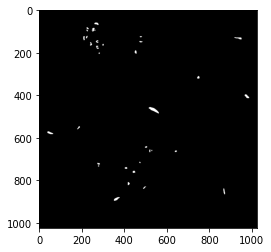

0m 3s 

Epoch 55/59
----------
epoch loss: tensor(0.2245, device='cuda:0', grad_fn=<AddBackward0>)
epoch dice: tensor([0.2541, 0.1955], device='cuda:0', grad_fn=<RsubBackward1>)
epoch bce: tensor(0.2243, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
unsupervised loss tensor(2.8895, device='cuda:0', grad_fn=<MeanBackward0>)
loss tensor(0.2267, device='cuda:0', grad_fn=<AddBackward0>)
0m 3s 

Epoch 56/59
----------
epoch loss: tensor(0.1846, device='cuda:0', grad_fn=<AddBackward0>)
epoch dice: tensor([0.2019, 0.2065], device='cuda:0', grad_fn=<RsubBackward1>)
epoch bce: tensor(0.1649, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
unsupervised loss tensor(1.4013, device='cuda:0', grad_fn=<MeanBackward0>)
loss tensor(0.1856, device='cuda:0', grad_fn=<AddBackward0>)
0m 3s 

Epoch 57/59
----------
epoch loss: tensor(0.1887, device='cuda:0', grad_fn=<AddBackward0>)
epoch dice: tensor([0.1829, 0.1475], device='cuda:0', grad_fn=<RsubBackward

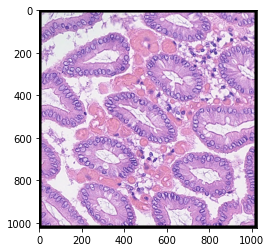

Predicted Mask Sigmoid


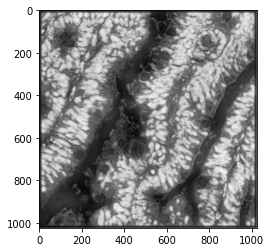

Actual Mask


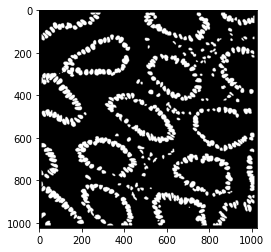

0m 3s 



In [ ]:
def create_model(ema=False):
  # Network definition
  model = ResNetUNet(1).to(device)
  if ema:
    for param in model.parameters():
        param.detach_()
  return model


model = create_model()
ema_model = create_model(ema=True)


optimizer_ft = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=1e-4)

exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=30, gamma=0.1)

loss_ls = train_model(optimizer_ft, exp_lr_scheduler, num_epochs=60)

ResNetUNet(
  (base_model): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, tra

In [ ]:
#fuck that
def update_ema_variables(model, ema_model, alpha, global_step):
    # Use the true average until the exponential average is more correct
    alpha = min(1 - 1 / (global_step + 1), alpha)
    for ema_param, param in zip(ema_model.parameters(), model.parameters()):
        ema_param.data.mul_(alpha).add_(1 - alpha, param.data)

def train_model(model, ema_model, optimizer, scheduler, num_epochs=25):
    best_model_wts = copy.deepcopy(model.state_dict())
    best_loss = 1e10
    ict_alpha = 0.2
    labeled_bs = 2
    
    loss_ls = []
    
    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        since = time.time()
        loss = 0
        
        for inputs, masks in train_loader:
            model.train()
            inputs = inputs.to(device)
            masks = masks.to(device).float()

            #ICT mix factors
            ict_mix_factors = np.random.beta(
                ict_alpha, ict_alpha, size=(labeled_bs // 2, 1, 1, 1))
            ict_mix_factors = torch.tensor(
                ict_mix_factors, dtype=torch.float).cuda()
            unlabeled_volume_batch_0 = unlabeled_volume_batch[0:labeled_bs // 2, ...]
            unlabeled_volume_batch_1 = unlabeled_volume_batch[labeled_bs // 2:, ...]

            #Mix images
            batch_ux_mixed = unlabeled_volume_batch_0 * \
                (1.0 - ict_mix_factors) + \
                unlabeled_volume_batch_1 * ict_mix_factors
            input_volume_batch = torch.cat(
                [labeled_volume_batch, batch_ux_mixed], dim=0)
            

            #volume_batch, label_batch = sampled_batch['image'], sampled_batch['label']
            volume_batch, label_batch = inputs.cuda(), masks.cuda()
            unlabeled_volume_batch = volume_batch[labeled_bs:]
            labeled_volume_batch = volume_batch[:labeled_bs]

            # ICT mix factors
            ict_mix_factors = np.random.beta(
                0.2, 0.2, size=(15//2, 1, 1, 1))
            ict_mix_factors = torch.tensor(
                ict_mix_factors, dtype=torch.float).cuda()
            unlabeled_volume_batch_0 = unlabeled_volume_batch[0:15, ...]
            unlabeled_volume_batch_1 = unlabeled_volume_batch[15//2:, ...]

            # Mix images
            batch_ux_mixed = unlabeled_volume_batch_0 * \
                (1.0 - ict_mix_factors) + \
                unlabeled_volume_batch_1 * ict_mix_factors
            input_volume_batch = torch.cat(
                [labeled_volume_batch, batch_ux_mixed], dim=0)
            
            optimizer.zero_grad()
            outputs = model(inputs)

            outputs_soft = torch.softmax(outputs, dim=1)
            ema_model = model
            with torch.no_grad():
                ema_output_ux0 = torch.softmax(
                    ema_model(unlabeled_volume_batch_0), dim=1)
                ema_output_ux1 = torch.softmax(
                    ema_model(unlabeled_volume_batch_1), dim=1)
                batch_pred_mixed = ema_output_ux0 * \
                    (1.0 - ict_mix_factors) + ema_output_ux1 * ict_mix_factors

            #loss_ce = ce_loss(outputs[:2],
            #                  label_batch[:2][:].long())
            #loss_dice = dice_loss(
            #    outputs_soft[:2], label_batch[:2].unsqueeze(1))
            supervised_loss = weighted_loss(label_batch[:2][:].long(), outputs[:2])
            #0.5 * (loss_dice + loss_ce)
            consistency_weight = get_current_consistency_weight(iter_num//150)
            #consistency_loss = torch.mean(
            #    (outputs_soft[15:] - batch_pred_mixed) ** 2)
            loss = supervised_loss + consistency_weight * consistency_loss

            update_ema_variables(model, ema_model, args.ema_decay, iter_num)
            #lr_ = base_lr * (1.0 - iter_num / max_iterations) ** 0.9
            #for param_group in optimizer.param_groups:
            #    param_group['lr'] = lr_

            

            
            epoch_loss = weighted_loss(outputs,masks,bce_weight=0.3)
            


        
        loss /= len(train_loader)
        print("epoch loss:", loss, "epoch_dice:", dice, "cross-entropy loss:", loss_ce, "epoch unsupervised_loss:", consistency_weight * consistency_loss)
        loss_ls.append(loss)
        
        if (epoch+1)%5==0:
            print("\n","Input Image")
            plt.imshow(reverse_transform(inputs.to('cpu').detach()[0]))
            plt.show()
            print("Predicted Mask Sigmoid")
            plt.imshow(outputs.to('cpu').detach().numpy()[0][0],cmap='gray')
            plt.show()
            print("Actual Mask")
            plt.imshow(masks.to('cpu').detach()[0],cmap='gray')
            plt.show()
        
        time_elapsed = time.time() - since
        print('{:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60),"\n")
    
    return loss_ls

In [ ]:
#################
# Training Loop #
#################

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

num_class = 1
model = ResNetUNet(num_class).to(device)
ema_model = ResNetUNet(num_class).to(device)


optimizer_ft = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=1e-4)

exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=30, gamma=0.1)

loss_ls = train_model(model, optimizer_ft, exp_lr_scheduler, num_epochs=60)

cuda:0


TypeError: ignored

In [ ]:
# torch.save(model.state_dict(), "./weights1")

In [ ]:
#################################
# Load model with saved weights #
#################################

# device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
# model = ResNetUNet(1)
# model.load_state_dict(torch.load("./weights1"))
# model.to(device)

In [ ]:
#fuck that
from torch.nn.modules.loss import CrossEntropyLoss
ce_loss = CrossEntropyLoss()

def dice_loss(score, target):
    target = target.float()
    smooth = 1e-5
    intersect = torch.sum(score * target)
    y_sum = torch.sum(target * target)
    z_sum = torch.sum(score * score)
    loss = (2 * intersect + smooth) / (z_sum + y_sum + smooth)
    loss = 1 - loss
    return loss


def dice_loss1(score, target):
    target = target.float()
    smooth = 1e-5
    intersect = torch.sum(score * target)
    y_sum = torch.sum(target)
    z_sum = torch.sum(score)
    loss = (2 * intersect + smooth) / (z_sum + y_sum + smooth)
    loss = 1 - loss
    return loss


def entropy_loss(p, C=2):
    # p N*C*W*H*D
    y1 = -1*torch.sum(p*torch.log(p+1e-6), dim=1) / \
        torch.tensor(np.log(C)).cuda()
    ent = torch.mean(y1)

    return ent


def softmax_dice_loss(input_logits, target_logits):
    """Takes softmax on both sides and returns MSE loss
    Note:
    - Returns the sum over all examples. Divide by the batch size afterwards
      if you want the mean.
    - Sends gradients to inputs but not the targets.
    """
    assert input_logits.size() == target_logits.size()
    input_softmax = F.softmax(input_logits, dim=1)
    target_softmax = F.softmax(target_logits, dim=1)
    n = input_logits.shape[1]
    dice = 0
    for i in range(0, n):
        dice += dice_loss1(input_softmax[:, i], target_softmax[:, i])
    mean_dice = dice / n

    return mean_dice
    
class DiceLoss(nn.Module):
    def __init__(self, n_classes):
        super(DiceLoss, self).__init__()
        self.n_classes = n_classes

    def _one_hot_encoder(self, input_tensor):
        tensor_list = []
        for i in range(self.n_classes):
            temp_prob = input_tensor == i * torch.ones_like(input_tensor)
            tensor_list.append(temp_prob)
        output_tensor = torch.cat(tensor_list, dim=1)
        return output_tensor.float()

    def _dice_loss(self, score, target):
        target = target.float()
        smooth = 1e-5
        intersect = torch.sum(score * target)
        y_sum = torch.sum(target * target)
        z_sum = torch.sum(score * score)
        loss = (2 * intersect + smooth) / (z_sum + y_sum + smooth)
        loss = 1 - loss
        return loss

    def forward(self, inputs, target, weight=None, softmax=False):
        if softmax:
            inputs = torch.softmax(inputs, dim=1)
        target = self._one_hot_encoder(target)
        if weight is None:
            weight = [1] * self.n_classes
        assert inputs.size() == target.size(), 'predict & target shape do not match'
        class_wise_dice = []
        loss = 0.0
        for i in range(0, self.n_classes):
            dice = self._dice_loss(inputs[:, i], target[:, i])
            class_wise_dice.append(1.0 - dice.item())
            loss += dice * weight[i]
        return loss / self.n_classes

dice_loss = DiceLoss(5)

In [ ]:
#######################
# Test Set Dataloader #
#######################

label_path = "./Test/Labels/"
img_path = "./Test/Images/"

test_set = NucleiDataset(img_path,label_path, transform = trans)

batch_size = 1

test_loader = DataLoader(test_set, batch_size=batch_size, shuffle=True, num_workers=1)

Input Image


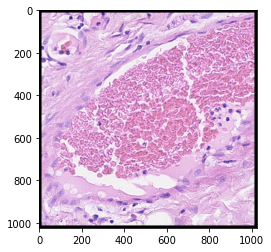

Predicted Mask Sigmoid


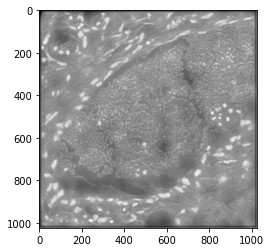

Predicted Mask Binary


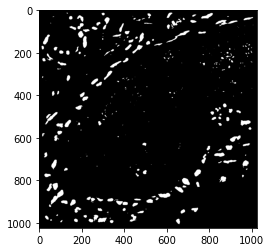

Actual Mask


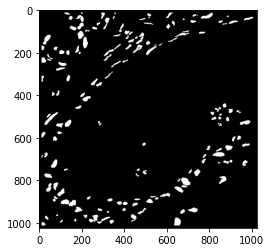

In [ ]:
inputs, masks = next(iter(test_loader))
print("Input Image")
plt.imshow(reverse_transform(inputs[0]))
plt.show()
outputs = model(inputs.to(device))
pred = outputs.to('cpu').detach().numpy()[0][0]

print("Predicted Mask Sigmoid")
plt.imshow(pred,cmap='gray')
plt.show()
threshold=0.95     # vary the threshold
pred[pred >= threshold] = 1
pred[pred < threshold] = 0
print("Predicted Mask Binary")
plt.imshow(pred,cmap='gray')
plt.show()
print("Actual Mask")
plt.imshow(masks[0],cmap='gray')
plt.show()